In [1]:
import os
import json
import torch
import pickle 
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from models import TransformerEncoder
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator 
from datasets import MVTSDataset, find_padding_masks
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Inputation Plots**

In [2]:
# Read in train and validation indices
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']

In [132]:
# Create loaders
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=len(train_indices), shuffle=False, drop_last=False)
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=len(val_indices), shuffle=False, drop_last=False)

In [133]:
# Load best trained model

model = TransformerEncoder(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256, 
                                    freeze=True)
model.float();
model.load_state_dict(torch.load('../temp/inputting_unity_norm.pt'));
model.eval();

In [134]:
x, mask, _ = next(iter(val_dataloader))
padding_mask = find_padding_masks(x) 
x = torch.nan_to_num(x)
x_masked = x * mask 
target_masks = ~mask  
x = x.to(device)
x_masked = x_masked.to(device)
target_masks = target_masks.to(device)
padding_mask = padding_mask.to(device)
y_hat, _ = model(x_masked, padding_mask)

/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_56155/4120012415.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0:2, :])


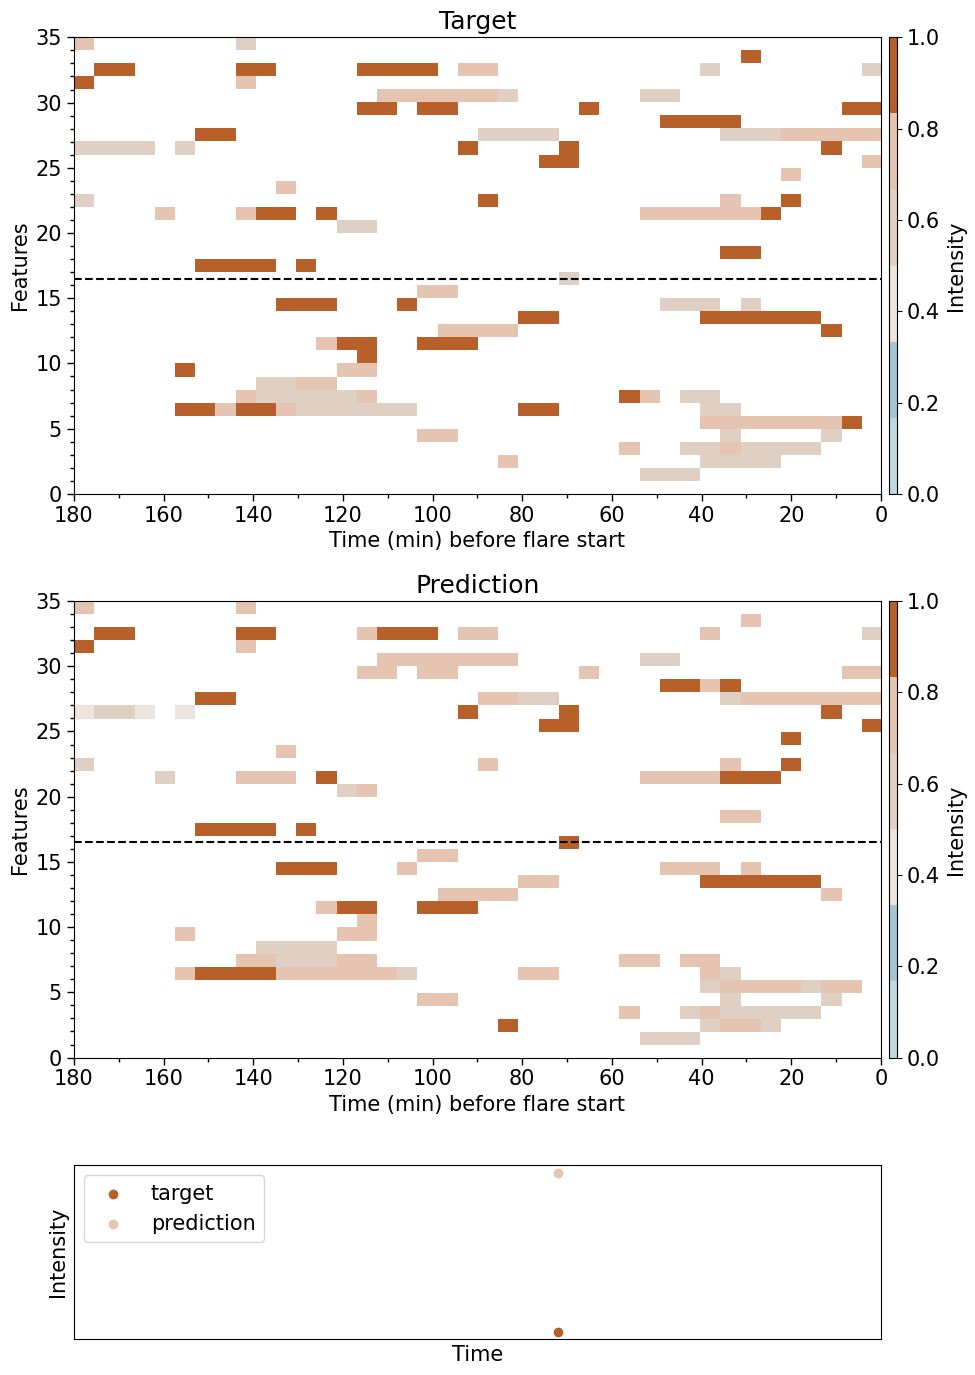

In [244]:
select_instance = 64
select_feature = 16
vertical_select = 14

prediction_array = torch.squeeze(y_hat)
target_array = torch.squeeze(x)
mask_array = torch.squeeze(x_masked)

prediction_array = y_hat[select_instance, :, :].T.detach().numpy()
target_array = x[select_instance, :, :].T.detach().numpy()
mask_array = target_masks[select_instance, :, :].T.detach().numpy()

target_array[~mask_array] = np.nan
prediction_array[~mask_array] = np.nan
prediction_vec = prediction_array[select_feature, :]
target_vec = target_array[select_feature, :]
mask_vec = mask_array[select_feature, :]

prediction_vec_fet = prediction_array[:, vertical_select]
target_vec_fet = target_array[:, vertical_select]
mask_vec_fet = mask_array[:, vertical_select]

mpl.rcParams['font.size'] = 15

# Create a custome color map 
with open('/Users/brandonlpanos/my_colors.pkl', 'rb') as f:
    my_colors = pickle.load(f)
# drop light_cream from the dictionary
my_colors.pop('light_cream')
# alternative color map
my_colors  = {
    'light_blue': '#C0D8E0',
    'dark_blue': '#A4C6D3',
    'light_brown': '#EDE4DD',
    'dark_brown': '#E0D0C4',
    'burn_brick': '#E5C5B2',
    'dark_brick': '#B86029'}
# create custome color map (discrete)
# Define the hex color values
hex_colors = [color for name, color in my_colors.items() ]
# Create the ListedColormap
custom_cmap = ListedColormap(hex_colors)

fig = plt.subplots(figsize=(10, 14))
gs = gridspec.GridSpec(5, 1)

ax1 = plt.subplot(gs[0:2, :])
ax1.set_title('Target')
ax1.set_ylabel('Features')
ax1.set_xlabel('Time (min) before flare start')
im1=ax1.imshow(target_array, aspect='auto', cmap=custom_cmap, label='target', extent=[180, 0, 35, 0], vmin=0., vmax=1)
ax1.axhline(y=select_feature+0.5, color='k', linestyle='--')
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
ax1.set_ylim(0,35)
cbar = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
cbar.set_label('Intensity')

ax2 = plt.subplot(gs[2:4, :])
ax2.set_title('Prediction')
ax2.set_ylabel('Features')
ax2.set_xlabel('Time (min) before flare start')
im2 = ax2.imshow(prediction_array, aspect='auto', cmap=custom_cmap, label='prediction', vmin=0., vmax=1, extent=[180, 0, 35, 0])
ax2.axhline(y=select_feature + 0.5, color='k', linestyle='--')
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
ax2.set_ylim(0,35)
cbar = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
cbar.set_label('Intensity')

ax3 = plt.subplot(gs[4, :])
ax3.set_xlabel('Time')
ax3.set_ylabel('Intensity')
ax3.scatter(range(len(target_vec)), target_vec, c='#B86029', label='target')
ax3.scatter(range(len(prediction_vec)), prediction_vec, c='#E5C5B2', label='prediction')
ax3.set_xlim(0,40)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.legend(loc='upper left')

plt.tight_layout()
# plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/denoising.png', dpi=300, bbox_inches='tight')
plt.show()

In [219]:
x, mask, _ = next(iter(val_dataloader))
padding_mask = find_padding_masks(x) 
x = torch.nan_to_num(x)
x_masked = x * mask 
target_masks = ~mask  
x = x.to(device)
x_masked = x_masked.to(device)
target_masks = target_masks.to(device)
padding_mask = padding_mask.to(device)
y_hat, _ = model(x_masked, padding_mask)
x_masked[x_masked == 0]  = np.nan

In [144]:
# Create a custome color map 
with open('/Users/brandonlpanos/my_colors.pkl', 'rb') as f:
    my_colors = pickle.load(f)
# create custome color map (discrete)
# Define the hex color values
hex_colors = [color for name, color in my_colors.items() ]
# Create the ListedColormap
custom_cmap = ListedColormap(hex_colors)

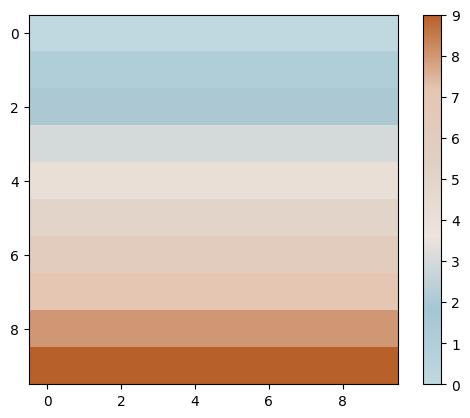

In [6]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the custom color values from the pickle file
with open('/Users/brandonlpanos/my_colors.pkl', 'rb') as f:
    my_colors = pickle.load(f)

my_colors  = {
    'light_blue': '#C0D8E0',
    'dark_blue': '#A4C6D3',
    'light_brown': '#EDE4DD',
    'dark_brown': '#E0D0C4',
    'burn_brick': '#E5C5B2',
    'dark_brick': '#B86029'}


# Extract the hex color values from the dictionary
hex_colors = [color for name, color in my_colors.items()]

# Create a normalized array of values ranging from 0 to 1
values = [i / (len(hex_colors) - 1) for i in range(len(hex_colors))]

# Create a dictionary to define the color map
color_dict = {'red': [], 'green': [], 'blue': []}

# Populate the color dictionary with the RGB values
for val, hex_color in zip(values, hex_colors):
    hex_color = hex_color.lstrip('#')  # Remove the '#' character
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255 for i in (0, 2, 4))
    color_dict['red'].append((val, rgb_color[0], rgb_color[0]))
    color_dict['green'].append((val, rgb_color[1], rgb_color[1]))
    color_dict['blue'].append((val, rgb_color[2], rgb_color[2]))

# Create the custom color map
custom_cmap = LinearSegmentedColormap('CustomMap', color_dict)

# Example usage: plot a gradient using the custom color map
data = [[i for _ in range(10)] for i in range(10)]
plt.imshow(data, cmap=custom_cmap)
plt.colorbar()
plt.show()

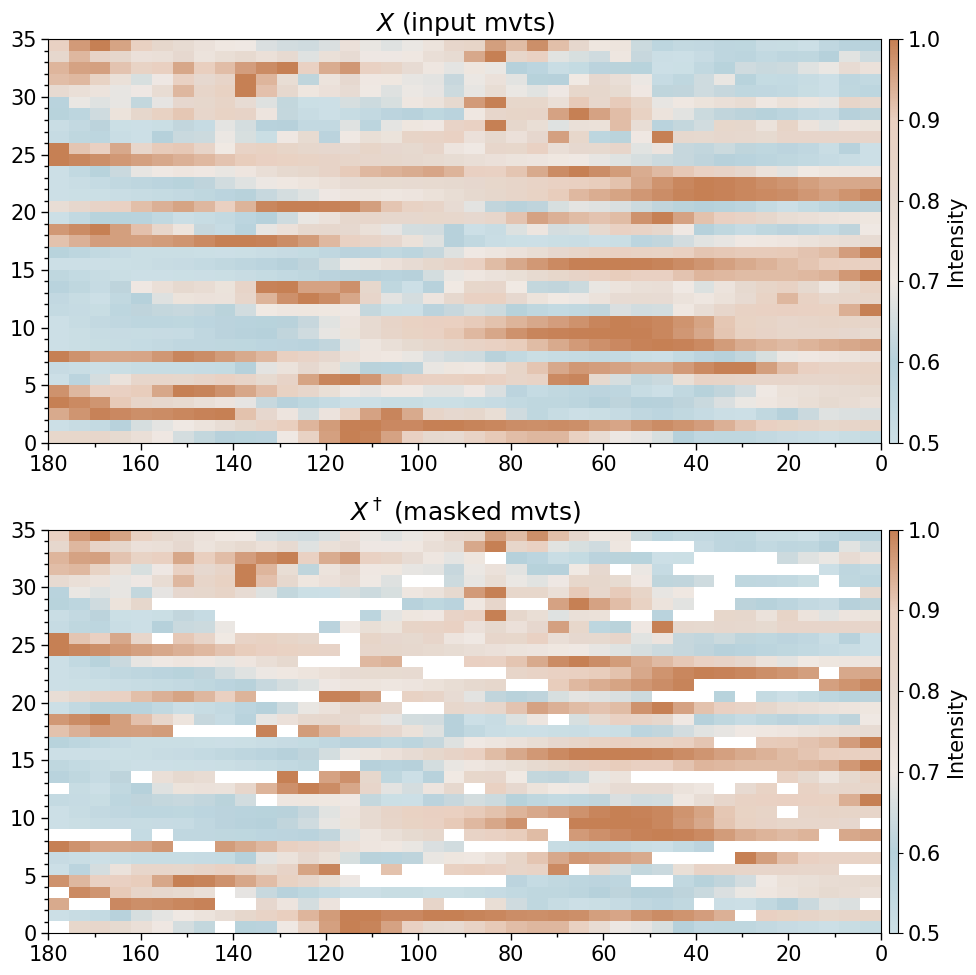

In [243]:
# Use descreet to see better 

indx = 64

mpl.rcParams['font.size'] = 15

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

im1 = ax1.imshow(x[indx].T, aspect='auto', cmap=custom_cmap, interpolation='none', label='target', extent=[180, 0, 0, 35], alpha=0.8)
ax1.set_title(r'$X$' + ' (input mvts)')
cbar1 = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
cbar1.set_label('Intensity')

# Plot the second subplot
im2 = ax2.imshow(x_masked[indx].T, aspect='auto', cmap=custom_cmap, interpolation='none', label='target', extent=[180, 0, 0, 35], alpha=0.8)
ax2.set_title(r'$X^\dagger$' + ' (masked mvts)')
# Add colorbar to the second subplot
cbar2 = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
cbar2.set_label('Intensity')

plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/autoregressive.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
plt.close()

**Grad-CAM**

In [249]:
import torch
import numpy as np
from models import CNNModel
import matplotlib.pyplot as plt
from datasets import MVTSDataset
import matplotlib.colors as mcolors
from captum.attr import GuidedGradCam
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.size'] = 8

In [263]:

def plot_attributions(mvts, attribution_mask, name=None):

    dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
            'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
            'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
            'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']

    mvts = mvts.T
    attribution_mask = attribution_mask.T


    mvts[mvts==0] = np.nan
    mvts = unity_based_normalization(mvts) # normalize the data so easier to see each feature in the original data

    n_void = np.isnan(mvts[0]).sum()

    fig = plt.figure(figsize=(10, 25))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1, 1, 1], hspace=0.15, wspace=0.3)

    # plot input mvt
    ax1 = fig.add_subplot(gs[0:1, :])
    ax1.set_title(f'mvts obs: {name}')
    ax1.imshow(mvts, aspect='auto', cmap='gray', interpolation='spline16', vmin=0, vmax=np.nanmax(mvts), alpha=0.5)
    ax1.yaxis.grid(True, "major")
    ax1.xaxis.grid(True, "major")
    ax1.xaxis.set_major_locator(MultipleLocator(2))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(1))
    ax1.tick_params(which='major', length=5,width=1)
    ax1.tick_params(which='minor', length=3,width=1)

    # Plot saliency map
    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('saliency map')
    attribution_mask[:,0:n_void] = np.nan
    ax2.imshow(attribution_mask, aspect='auto', cmap=custom_cmap, alpha=1, interpolation='spline16')
    ax2.yaxis.grid(True, "major")
    ax2.xaxis.grid(False, "major")
    ax2.xaxis.set_major_locator(MultipleLocator(2))
    ax2.xaxis.set_minor_locator(MultipleLocator(1))
    ax2.yaxis.set_major_locator(MultipleLocator(5))
    ax2.yaxis.set_minor_locator(MultipleLocator(1))
    ax2.tick_params(which='major', length=5,width=1)
    ax2.tick_params(which='minor', length=3,width=1)

    # Plot the light curves
    gs2 = gridspec.GridSpecFromSubplotSpec(6, 6, subplot_spec=gs[2, 0:], wspace=0, hspace=0)
    for i in range(6):
        for j in range(6):
            ind = (i * 6) + j
            if ind < len(dtypes):  # Check if index is within the range of dtypes
                ax = fig.add_subplot(gs2[i, j])
                # Handle NaN values in attribution_mask
                masked_mask = np.ma.masked_invalid(attribution_mask)
                # Normalize the masked_mask to range [0, 1]
                norm = mcolors.Normalize(vmin=masked_mask.min(), vmax=masked_mask.max())
                normalized_mask = norm(masked_mask)
                # Convert the normalized mask to RGB
                cmap = custom_cmap
                rgb_colors = cmap(normalized_mask)
                light_curve = mvts[ind]
                light_curve_colors = rgb_colors[ind, :, :]
                for k, clr in enumerate(light_curve_colors):
                    if k + 1 == 40: break
                    x = [k, k+1]
                    y = [light_curve[k], light_curve[k+1]]
                    plt.plot(x, y, color=clr, linewidth=0.7)
                    plt.text(0.02, 0.9, dtypes[ind], fontsize=5, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
                    plt.xticks([])
                    plt.yticks([])
                    plt.xlim(0,40)
    plt.tight_layout()
    plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/grad_cam//{name}.png', bbox_inches='tight')
    plt.close(fig)

    return None

def unity_based_normalization(data):
    '''
    Normalize each row of the data matrix by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    Takes in arrays of shape (features, time)
    '''
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    # Get the maximum and minimum values of each row
    max_vals = np.nanmax(data, axis=1)
    min_vals = np.nanmin(data, axis=1)
    # Compute the range of each row, and add a small constant to avoid division by zero
    ranges = max_vals - min_vals
    eps = np.finfo(data.dtype).eps  # machine epsilon for the data type
    ranges[ranges < eps] = eps
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    data = (data - min_vals[:, np.newaxis]) / ranges[:, np.newaxis]
    data = data + np.nanmax(data)
    data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
    return data

In [264]:
# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, labels = next(iter(dataloader))

In [265]:
# Itterate over all mvts
for indx, (x, y) in enumerate(zip(data, labels)):
    if y.item() == 0: continue
    name = indices[indx]
    x = x.unsqueeze_(0)
    x = x.unsqueeze_(1)
    x = x.requires_grad_()
    x = torch.nan_to_num(x)
    attribution_masks = []
    # Itterate over all models from each 50 folds 
    for model_indx in range(50):
        if model_indx in [27,37]: continue
        # Load best model for a specific fold
        model = CNNModel()
        model.load_state_dict(torch.load(f'../models/cnn_std/{model_indx}.pth', map_location=torch.device('cpu')))
        model.eval();
        # Create a GuidedGradCam object based on the model and the desired layer
        guided_grad_cam = GuidedGradCam(model, model.conv3)
        # Compute the attribution mask for the desired class
        attribution_mask = guided_grad_cam.attribute(x, target=y)
        attribution_mask = attribution_mask.squeeze().detach().numpy()
        # attribution_mask = attribution_mask / np.nanmax(attribution_mask)
        attribution_mask = unity_based_normalization(attribution_mask)
        attribution_masks.append(attribution_mask)
        # delete model
        del model
    x = x.squeeze().detach().numpy()
    attribution_masks = np.array(attribution_masks)
    attribution_mask = np.nanmean(attribution_masks, axis=0)
    plot_attributions(x, attribution_mask, name=name, )
    # np.save(f'/Users/brandonlpanos/papers/transformer/figs/grad_cam/{name}.npy', attribution_mask)

/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_56155/3567766926.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_56155/3567766926.py:95: RuntimeWarning: divide by zero encountered in divide
  data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_56155/3567766926.py:95: RuntimeWarning: invalid value encountered in multiply
  data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
